In [1]:
"""
Summaries of USFS TreeMap linked to FIA plot data
Emphasis on 
    - Metrics of forest composition
    - Ecological gradients of species dominance
    - Forest structure (abundance, dominance, diversity, stand height)

Aggregate these statistics to FRP gridcells.

Author: maxwell.cook@colorado.edu
"""

import os, sys

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

albers = 'EPSG:5070' # albers CONUS
utm = 'EPSG:32613' # UTM Zone 13N

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# load the aggregated FRP grids (regular 375m2 grids summarizing FRP from VIIRS)
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
print(f"\nThere are [{len(grid)}] grids across [{len(grid['Fire_ID'].unique())}] fires.\n")

# create a unique ID
grid['grid_idx'] = grid['Fire_ID'].astype(str) + grid['grid_index'].astype(str)

# add the centroid lat/lon to the grid data
df = grid.to_crs(4326) # WGS coords for lat/lon
df['x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['y'] = df.geometry.centroid.y
grid = grid.merge(df[['grid_idx','x','y']], on='grid_idx', how='left')
del df
print(f"\n{grid.columns}\n")

# Drop any dupicate grids ...
print(f"Dropping [{grid.duplicated(subset=['grid_idx']).sum()}] duplicate grids.\n")
grid = grid.drop_duplicates(subset=['grid_idx'], keep='first')


There are [57232] grids across [100] fires.


Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'grid_idx', 'x', 'y'],
      dtype='object')

Dropping [0] duplicate grids.



Fractional overlap:
count    57232.000000
mean         2.023404
std          2.001402
min          0.000003
25%          0.587511
50%          1.493563
75%          2.771206
max         24.470760
Name: overlap, dtype: float64



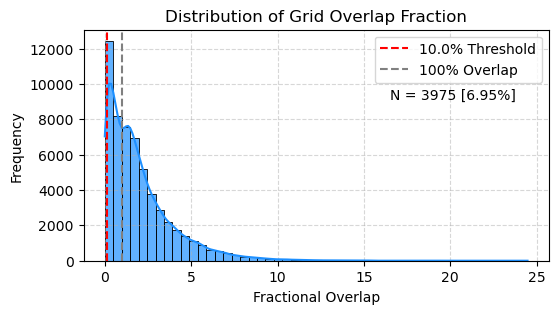

Plot saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/grid_overlap_distribution.png


In [3]:
# Check out the distribution of grid overlap with FRP observations
thresh = 0.10
print(f"Fractional overlap:\n{grid['overlap'].describe()}\n")
n_small = grid[grid['overlap'] < thresh]['grid_idx'].count() # less than 5% spatial overlap

# Plot the distribution of the fractional overlap
plt.figure(figsize=(6,3))
sns.histplot(grid['overlap'], kde=True, bins=50, color='dodgerblue', alpha=0.7)

# Add vertical line for the threshold and for 100%
plt.axvline(x=thresh, color='red', linestyle='--', label=f'{thresh*100}% Threshold')
plt.axvline(x=1, color='grey', linestyle='--', label='100% Overlap')

# Customize the plot
plt.title('Distribution of Grid Overlap Fraction')
plt.xlabel('Fractional Overlap')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.text(16.5, plt.ylim()[1] * 0.7, 
         f'N = {n_small} [{round(n_small/len(grid)*100,2)}%]', 
         fontsize=10, color='black')

# Save the plot
out_path = os.path.join(projdir, 'figures/grid_overlap_distribution.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight')

plt.show()
print(f"Plot saved to: {out_path}")

In [4]:
# filter out grids below the overlap threshold
print(f"Dropping [{n_small} ({round(n_small/len(grid)*100,2)}%)] grids with <{thresh*100}% fractional overlap.")
grid = grid[grid['overlap'] >= thresh] # remove these observations
print(len(grid))

Dropping [3975 (6.95%)] grids with <10.0% fractional overlap.
53257


In [5]:
# Load the TreeMap (ca. 2016)
# Pixel values here denote the FIA plot ID ("tm_id")
# see '04a_TreeMap_FIA-Prep.ipynb'
# fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016.tif') # tm_id band
fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_TMID_FORTYPCD.tif") # multi-band
treemap_da = rxr.open_rasterio(fp, masked=True, cache=False).squeeze()
tmid_da = treemap_da.sel(band=1) # the "tm_id" band

# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = tmid_da.shape, tmid_da.spatial_ref.GeoTransform, tmid_da.rio.crs, tmid_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {tmid_da[0].dtype}")

del treemap_da
gc.collect()

Shape: (28724, 17006); 
GeoTransform: -1193295.0 30.0 0.0 2253345.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


131

In [6]:
# create a forest/non-forest grid
forest_mask = xr.where(~np.isnan(tmid_da), 1, 0)
# calculate the total forested pixels
# see __functions.py 'compute_band_stats'
forest_pct = compute_band_stats(grid, forest_mask, 'grid_idx', attr='constant')
forest_pct.rename(columns={
    'pct_cover': 'forest_pct',
    'total_pixels': 'forest_pixels'
}, inplace=True)
forest_pct = forest_pct[forest_pct['constant'] == 1] # just forest pixels
forest_pct = forest_pct[['grid_idx','forest_pixels','forest_pct']]

# how many forested grids are there? (>50%)
n_forest = len(forest_pct[forest_pct['forest_pct'] > 50])
print(f"\n[{round(n_forest/len(grid)*100,2)}%] predominantly forest grids.")
print(f"\n{forest_pct.head(3)}")

# Save as a GeoTIFF
out_fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_forestmask.tif")
forest_mask.rio.to_raster(out_fp, compress='zstd', zstd_level=9, dtype='uint16', driver='GTiff')
print(f"\nSaved multi-band raster to: {out_fp}")

# Join to the grid data
grid = grid.merge(forest_pct, on='grid_idx', how='left')
print(f"\n{grid.columns}")

print("\n~~~~~~~~~~~~~~~\n")
del forest_mask, forest_pct
gc.collect() # clean up


[87.0%] predominantly forest grids.

    grid_idx  forest_pixels  forest_pct
0  161955421            169  100.000000
2  161955422            182   91.758242
4  161955423            169   73.372781

Saved multi-band raster to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/USFS/TreeMap_2016_forestmask.tif

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Nam

16

## TreeMap Tree Table

Summary of the the TreeMap Tree Table information within forested grids identified above. Specifically, we can retrieve an estimate of aspen abundance that goes beyond the algorithmic forest type code assigned to a pixel. In this, we can infer understory/overstory compositions potential to that area.

In [7]:
# get the count/proportion of unique "tm_id" from TreeMap in grids
t0 = time.time()

# see __functions.py
grid_trees = compute_band_stats(grid, tmid_da, 'grid_idx', attr='tm_id')

# tidy columns in the summary table
grid_trees['count'] = grid_trees['count'].astype(int)
grid_trees['total_pixels'] = grid_trees['total_pixels'].astype(int)
grid_trees.rename(columns={
    'count': 'tmid_count',
    'pct_cover': 'tmid_pct'
}, inplace=True)

# load the TreeMap Tree Table
fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016_tree_table.csv')
tree_tbl = pd.read_csv(fp)
print(tree_tbl.columns)

# join the Tree Table to the grid data
grid_trees = grid_trees.merge(tree_tbl, on='tm_id', how='left')
print(f"\n{grid_trees.head(12)}")

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

del tmid_da, tree_tbl # clean up 
gc.collect()

Index(['tm_id', 'CN', 'STATUSCD', 'TPA_UNADJ', 'SPCD', 'COMMON_NAME',
       'SCIENTIFIC_NAME', 'SPECIES_SYMBOL', 'DIA', 'HT', 'ACTUALHT', 'CR',
       'SUBP', 'TREE', 'AGENTCD'],
      dtype='object')

     grid_idx  tm_id  tmid_count  total_pixels  tmid_pct            CN  \
0   161955421   5490           3           169  1.775148  3.123179e+13   
1   161955421   5490           3           169  1.775148  3.123179e+13   
2   161955421   5490           3           169  1.775148  3.123179e+13   
3   161955421   5490           3           169  1.775148  3.123179e+13   
4   161955421   5490           3           169  1.775148  3.123179e+13   
5   161955421   5490           3           169  1.775148  3.123179e+13   
6   161955421   5490           3           169  1.775148  3.123179e+13   
7   161955421   5490           3           169  1.775148  3.123179e+13   
8   161955421   5490           3           169  1.775148  3.123179e+13   
9   161955421  12327           1           169  0.591716 

44

In [8]:
# Calculate the Tree Table statistics across tm_id/grid_index combinations
#### Abundance (trees/acre, scaled to per-pixel)
#### Dominance (live basal area, scaled to per-pixel)
#### Tree height (average/species)

# force species name to lower case
grid_trees.rename(columns={'COMMON_NAME': 'species'}, inplace=True)
grid_trees['species'] = grid_trees['species'].str.lower()
# tidy the live/dead column
grid_trees['live_dead'] = (grid_trees['STATUSCD'] == 1).astype(int)
# add a tree/pixel based on scaling factor
grid_trees['tpp_unadj'] = grid_trees['TPA_UNADJ'] * 0.222395
# calculate live basal area (balive) scaled by TPA
grid_trees['BA'] = np.pi * (grid_trees['DIA'] / 2) ** 2  # Basal area in square feet
grid_trees['BA_TPAsc'] = grid_trees['BA'] * grid_trees['tpp_unadj']  # adjust based on tree abundance

# group by grid_index and plot identifier (tm_id)
# calculate statistics for live/dead seperately
# merge into a single dataframe

# live trees
live_metrics = (
    grid_trees[grid_trees['live_dead'] == 1]
    .groupby(['grid_idx', 'tm_id', 'species'], as_index=False)
    .agg(
        # grid-level attributes
        tmid_pixels=('tmid_count','max'), # retains the tm_id pixel count
        tmid_pct=('tmid_pct','max'), # retain the percent of forested area
        # shannon_h=('shannon_h','max'), # retains the tm_id shannon index
        # calculate species-level attributes
        tpp_live=('tpp_unadj','sum'), # sum of the trees/pixel
        ba_live=('BA_TPAsc', 'sum'),    # total BALIVE
        tree_ht_live=('ACTUALHT','mean') # average tree height
    )
)

# dead trees
dead_metrics = (
    grid_trees[grid_trees['live_dead'] == 0]
    .groupby(['grid_idx', 'tm_id', 'species'], as_index=False)
    .agg(
        tpp_dead=('tpp_unadj','sum'), # sum of the trees/pixel
        ba_dead=('BA_TPAsc', 'sum'),    # Live basal area
        tree_ht_dead=('ACTUALHT','mean') # average tree height
    )
)

# combine live/dead balive
tree_metrics = live_metrics.merge(
    dead_metrics, 
    on=['grid_idx', 'tm_id', 'species'], 
    how='outer'
).fillna(0)

# subset to the tree metric columns
tree_metrics = tree_metrics[['grid_idx','tm_id','tmid_pixels','tmid_pct','species',
                             'ba_live','ba_dead', # basal area
                             'tpp_live','tpp_dead', # trees/pixel
                             'tree_ht_live','tree_ht_dead']] # tree height

# Add Quadratic Mean Diameter (QMD) for live and dead trees
tree_metrics['qmd_live'] = np.where(
    tree_metrics['tpp_live'] > 0, 
    np.sqrt(tree_metrics['ba_live'] / (tree_metrics['tpp_live'] * 0.005454)), 
    0
)
tree_metrics['qmd_dead'] = np.where(
    tree_metrics['tpp_dead'] > 0, 
    np.sqrt(tree_metrics['ba_dead'] / (tree_metrics['tpp_dead'] * 0.005454)), 
    0
)

# Add combined (live + dead)
tree_metrics['tpp_ld'] = tree_metrics['tpp_live'] + tree_metrics['tpp_dead']
tree_metrics['ba_ld'] = tree_metrics['ba_live'] + tree_metrics['ba_dead']
tree_metrics['qmd_ld'] = tree_metrics['qmd_live'] + tree_metrics['qmd_dead']

# add in forest percent by grid
tree_metrics = tree_metrics.merge(
    grid[['grid_idx','forest_pixels','forest_pct']], 
    on='grid_idx', 
    how='left'
)

# filter out any rows with missing information
tree_metrics = tree_metrics[tree_metrics['tmid_pixels'] > 0]
print(f"\n{tree_metrics.head(12)}\n")
del live_metrics, dead_metrics, grid_trees
gc.collect()


   grid_idx  tm_id  tmid_pixels  tmid_pct                      species  \
0   0817469   5583          1.0  0.598802  common or two-needle pinyon   
1   0817469   5583          1.0  0.598802                 utah juniper   
2   0817469  11500          2.0  1.197605                quaking aspen   
3   0817469  11500          2.0  1.197605                    white fir   
4   0817469  11894          1.0  0.598802                quaking aspen   
5   0817469  12132          1.0  0.598802                quaking aspen   
6   0817469  12132          1.0  0.598802                subalpine fir   
7   0817469  12134          1.0  0.598802                quaking aspen   
8   0817469  12182          1.0  0.598802             engelmann spruce   
9   0817469  12182          1.0  0.598802                quaking aspen   
10  0817469  12182          1.0  0.598802                subalpine fir   
11  0817469  12262          1.0  0.598802                quaking aspen   

        ba_live      ba_dead   tpp_l

0

In [9]:
unique_spp = tree_metrics['species'].unique()
unique_spp

array(['common or two-needle pinyon', 'utah juniper', 'quaking aspen',
       'white fir', 'subalpine fir', 'engelmann spruce', 'lodgepole pine',
       'douglas-fir', 'ponderosa pine', 'gambel oak', 'blue spruce',
       'corkbark fir', 'loblolly pine', 'sweetgum', 'winged elm',
       'limber pine', 'grand fir', 'western larch', 'oneseed juniper',
       'southwestern white pine', 'alligator juniper',
       'arizona white oak', 'rocky mountain bristlecone pine',
       'singleleaf pinyon', 'rocky mountain juniper',
       'california juniper', 'bigtooth maple', 'arizona pinyon pine',
       'arizona madrone', 'chihuahuan pine', 'mexican pinyon pine',
       'netleaf oak', 'silverleaf oak', 'black cottonwood',
       'california red fir', 'western white pine', 'california black oak',
       'knobcone pine', 'sugar pine', 'american basswood', 'black cherry',
       'flowering dogwood', 'mockernut hickory', 'northern red oak',
       'pignut hickory', 'post oak', 'sourwood', 'southern 

In [10]:
pj = tree_metrics['species'].str.contains('pinon|pinyon|juniper', regex=True)
tree_metrics[pj]['species'].value_counts()

species
common or two-needle pinyon    141452
rocky mountain juniper         122084
utah juniper                    92757
western juniper                 41258
alligator juniper               39442
oneseed juniper                 34850
singleleaf pinyon               13654
arizona pinyon pine              6936
california juniper               5316
redberry juniper                 3992
ashe juniper                      108
mexican pinyon pine                87
border pinyon                      47
pinchot juniper                     9
Name: count, dtype: int64

In [11]:
# Identify the primary species from the Tree Table
# identify the species which make up 97% of landscape
spp_pr = (
    tree_metrics.groupby('species', as_index=False)
    .agg(
        balive=('ba_live', 'sum'),
        ba_ld=('ba_ld', 'sum'),
        tpa_live=('tpp_live', 'sum'),
        tpa_ld=('tpp_ld', 'sum') # live+dead
    )
)
# calculate the fractions for both BALIVE and TPA
spp_pr['balive_f'] = spp_pr['balive'] / spp_pr['balive'].sum()
spp_pr['ba_ld_f'] = spp_pr['ba_ld'] / spp_pr['ba_ld'].sum() # live+dead
spp_pr['tpa_live_f'] = spp_pr['tpa_live'] / spp_pr['tpa_live'].sum()
spp_pr['tpa_ld_f'] = spp_pr['tpa_ld'] / spp_pr['tpa_ld'].sum() # live+dead
# sort values and gather the primary species
spp_pr = spp_pr.sort_values(by='ba_ld_f', ascending=False)
# which species make up 97% of observations?
spp_pr['balive_f_csum'] = spp_pr['balive_f'].cumsum()
spp_pr['ba_ld_f_csum'] = spp_pr['ba_ld_f'].cumsum() # live+dead
spp_pr['tpa_live_f_csum'] = spp_pr['tpa_live_f'].cumsum()
spp_pr['tpa_ld_f_csum'] = spp_pr['tpa_ld_f'].cumsum() # live+dead

metric = 'ba_ld_f_csum'
top_species = spp_pr[(spp_pr['ba_ld_f_csum'] <= 0.97) | (spp_pr['tpa_ld_f_csum'] <= 0.97)]
print(f"\nSpecies making up 97% of *{metric}*: \n\n{top_species[['species','ba_ld_f','tpa_ld_f']]}\n\n")

del spp_pr
gc.collect()


Species making up 97% of *ba_ld_f_csum*: 

                         species   ba_ld_f  tpa_ld_f
132               ponderosa pine  0.220492  0.124422
99                lodgepole pine  0.177650  0.241405
135                quaking aspen  0.087997  0.100111
64                   douglas-fir  0.081831  0.053394
74              engelmann spruce  0.066890  0.054323
171                subalpine fir  0.059614  0.090617
185                 utah juniper  0.043445  0.017515
200                    white fir  0.040708  0.029737
80                     grand fir  0.028874  0.018297
59   common or two-needle pinyon  0.025384  0.027907
78                    gambel oak  0.024942  0.134455
146       rocky mountain juniper  0.014956  0.012068
92                  jeffrey pine  0.012398  0.004739
116              oneseed juniper  0.011563  0.003843
61                  corkbark fir  0.008638  0.006890
95                   limber pine  0.008347  0.007108
0              alligator juniper  0.007560  0.002880
19

0

In [12]:
# subset to Southern Rockies species
srm_spps = [
    'ponderosa pine', 'lodgepole pine', 'quaking aspen', 'douglas-fir',
    'engelmann spruce', 'subalpine fir', 'utah juniper', 'white fir',
    'common or two-needle pinyon', 'gambel oak',
    'rocky mountain juniper', 'oneseed juniper',
    'limber pine', 'singleleaf pinyon', 
    'blue spruce', 'curlleaf mountain-mahogany'
]

# get the species co-occurrence percentages
coo = get_spp_coo(tree_metrics, srm_spps, grid_col='tm_id', sp_col='species') # see '__functions.py')
print(f"\n{coo.head(30)}\n")


Species occurrence counts:
species
ponderosa pine                 531374
douglas-fir                    351699
lodgepole pine                 317188
quaking aspen                  248366
engelmann spruce               199412
subalpine fir                  182388
gambel oak                     168124
common or two-needle pinyon    141452
white fir                      130787
rocky mountain juniper         122084
utah juniper                    92757
limber pine                     60402
oneseed juniper                 34850
blue spruce                     22778
curlleaf mountain-mahogany      14105
singleleaf pinyon               13654
Name: count, dtype: int64


                                         species_pair  coo_count    coo_pct
21                      (douglas-fir, ponderosa pine)        787  12.848980
35                  (engelmann spruce, subalpine fir)        607   9.910204
72                    (lodgepole pine, subalpine fir)        484   7.902041
0         (common or two

In [13]:
# Subset to Southern Rockies species
tree_metrics = tree_metrics[tree_metrics['species'].isin(srm_spps)]
# Aggregate species into forest groups
# These groups represent common pairings for the Southern Rockies
spp_grouping = {
    'common or two-needle pinyon|singleleaf pinyon|utah juniper|oneseed juniper|rocky mountain juniper': 'Piñon-juniper',
    'engelmann spruce|subalpine fir|blue spruce': 'Spruce-fir',
    'ponderosa pine': 'Ponderosa', 
    'lodgepole pine': 'Lodgepole',
    'aspen': 'Quaking aspen',
    'douglas-fir|white fir|limber pine': 'Mixed-conifer',
    'gambel oak': 'Gambel oak',
}
# remap the species to groups
spp_remap = {} # dictionary to store the remap values
# Iterate over groups to create the species remap dictionary
for keywords, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = tree_metrics[tree_metrics['species'].str.contains(keywords, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update({name: spp_group for name in spp['species'].unique()})
    
# Apply the remap to create a new grouped species column
tree_metrics['species_gp_n'] = tree_metrics['species'].map(spp_remap).fillna(tree_metrics['species'])
# Verify the updated species groups
print(tree_metrics[['species', 'species_gp_n']].drop_duplicates().head(10))
print(f"\n{tree_metrics.columns}")

                        species   species_gp_n
0   common or two-needle pinyon  Piñon-juniper
1                  utah juniper  Piñon-juniper
2                 quaking aspen  Quaking aspen
3                     white fir  Mixed-conifer
6                 subalpine fir     Spruce-fir
8              engelmann spruce     Spruce-fir
13               lodgepole pine      Lodgepole
26                  douglas-fir  Mixed-conifer
27               ponderosa pine      Ponderosa
37                   gambel oak     Gambel oak

Index(['grid_idx', 'tm_id', 'tmid_pixels', 'tmid_pct', 'species', 'ba_live',
       'ba_dead', 'tpp_live', 'tpp_dead', 'tree_ht_live', 'tree_ht_dead',
       'qmd_live', 'qmd_dead', 'tpp_ld', 'ba_ld', 'qmd_ld', 'forest_pixels',
       'forest_pct', 'species_gp_n'],
      dtype='object')


In [14]:
# re-aggregate the TreeMap characteristics by FRP grid/species combinations
# summarizes forest metrics by individual species present in the grid cell
# now, summarizes against the new forest groups made above
grid_tm = (
    tree_metrics.groupby(
        ['grid_idx', 'species_gp_n'], as_index=False
    ).agg(
        tmid_n=('tm_id', 'nunique'), # number of unique tm_id contributing
        forest_pct=('forest_pct','max'), # retains the forest pixel count for the grid
        ba_live=('ba_live', 'sum'),
        ba_dead=('ba_dead', 'sum'), 
        ba_ld=('ba_ld', 'sum'),
        tpp_live=('tpp_live', 'sum'),  
        tpp_dead=('tpp_dead', 'sum'),
        tpp_ld=('tpp_ld', 'sum'),
        qmd_live=('qmd_live', 'mean'),
        qmd_dead=('qmd_dead', 'mean'),
        qmd_ld=('qmd_ld', 'mean'),
        tree_ht_live=('tree_ht_live', 'mean'),
        tree_ht_dead=('tree_ht_dead', 'mean')
    )
)

# Check results
print(f"\n{grid_tm.head(10)}\n")

# clean up !
del tree_metrics
gc.collect()


  grid_idx   species_gp_n  tmid_n  forest_pct       ba_live       ba_dead  \
0  0817469     Gambel oak       1   98.816568    845.837710      0.000000   
1  0817469      Lodgepole       9   98.816568   6058.579777   3677.065638   
2  0817469  Mixed-conifer       9   98.816568   8848.258075    830.450951   
3  0817469  Piñon-juniper       1   98.816568   4364.599856    202.727454   
4  0817469      Ponderosa       1   98.816568   1346.204478      0.000000   
5  0817469  Quaking aspen      20   98.816568  36778.616375  11422.829016   
6  0817469     Spruce-fir      19   98.816568  36429.859434   5268.296401   
7  0817470     Gambel oak       1   97.802198    845.837710      0.000000   
8  0817470      Lodgepole       6   97.802198   4732.052349   2165.040068   
9  0817470  Mixed-conifer      12   97.802198  12491.305245    370.062222   

          ba_ld     tpp_live    tpp_dead       tpp_ld    qmd_live   qmd_dead  \
0    845.837710   118.041707    0.000000   118.041707   36.246678   0.0

56

In [15]:
# Re-assess the primary species after the regrouping
spp_pr = (
    grid_tm.groupby('species_gp_n', as_index=False)
    .agg(
        ba_ld=('ba_ld','sum'),
        tpp_ld=('tpp_ld', 'sum')
    )
)

# calculate the fraction
spp_pr['balive_f'] = spp_pr['ba_ld'] / spp_pr['ba_ld'].sum()
spp_pr['tpa_live_f'] = spp_pr['tpp_ld'] / spp_pr['tpp_ld'].sum()
# sort values and gather the primary species
spp_pr = spp_pr.sort_values(by='balive_f', ascending=False)
# which species make up 97% of observations?
spp_pr['balive_f_csum'] = spp_pr['balive_f'].cumsum()
spp_pr['tpa_live_f_csum'] = spp_pr['tpa_live_f'].cumsum()
top_species = spp_pr[(spp_pr['balive_f_csum'] <= 0.97) | (spp_pr['balive_f'] > 0.01)]
print(
    f"\nSpecies making up 97% of the total *tpa_live_f_csum*: \n\n",
    f"{top_species[['species_gp_n','balive_f','tpa_live_f']]}\n\n")

del spp_pr
gc.collect()


Species making up 97% of the total *tpa_live_f_csum*: 

     species_gp_n  balive_f  tpa_live_f
4      Ponderosa  0.252413    0.137830
1      Lodgepole  0.203370    0.267419
2  Mixed-conifer  0.149835    0.099964
6     Spruce-fir  0.149289    0.163867
3  Piñon-juniper  0.113661    0.069711
5  Quaking aspen  0.100736    0.110899
0     Gambel oak  0.028553    0.148944




0

In [16]:
grid_tm_spp = grid_tm[grid_tm['species_gp_n'].isin(top_species['species_gp_n'].unique())]
print(grid_tm_spp['species_gp_n'].unique())
print(f"{len(grid_tm_spp)} / {len(grid_tm)} with our predominant species.")
spps = grid_tm_spp['species_gp_n'].unique()

['Gambel oak' 'Lodgepole' 'Mixed-conifer' 'Piñon-juniper' 'Ponderosa'
 'Quaking aspen' 'Spruce-fir']
291511 / 301699 with our predominant species.


In [17]:
# get the species co-occurrence percentages
coo = get_spp_coo(grid_tm_spp, spps, grid_col='grid_idx', sp_col='species_gp_n') # see '__functions.py')
print(f"\n{coo.head(30)}\n")


Species occurrence counts:
species_gp_n
Mixed-conifer    49098
Piñon-juniper    47167
Ponderosa        43552
Lodgepole        41964
Quaking aspen    38880
Spruce-fir       37758
Gambel oak       33092
Name: count, dtype: int64


                      species_pair  coo_count    coo_pct
11  (mixed-conifer, piñon-juniper)      43901  82.958862
6       (lodgepole, mixed-conifer)      40778  77.057390
12      (mixed-conifer, ponderosa)      40613  76.745592
15      (piñon-juniper, ponderosa)      40510  76.550955
13  (mixed-conifer, quaking aspen)      38179  72.146110
14     (mixed-conifer, spruce-fir)      36879  69.689526
7       (lodgepole, piñon-juniper)      36621  69.201988
10         (lodgepole, spruce-fir)      36306  68.606739
9       (lodgepole, quaking aspen)      36013  68.053062
20     (quaking aspen, spruce-fir)      34783  65.728755
16  (piñon-juniper, quaking aspen)      34347  64.904855
8           (lodgepole, ponderosa)      33020  62.397249
17     (piñon-juniper, spruce

In [18]:
# check on the aspen composition
# how many grids have at least some aspen component?
spp_idx = grid_tm_spp[grid_tm_spp['species_gp_n'] == 'Quaking aspen']['grid_idx'].unique() # list of grid indices
grid_aspen = grid_tm_spp[grid_tm_spp['grid_idx'].isin(spp_idx)]
# check how many aspen gridcells there are
n_spp_grids = len(grid_aspen['grid_idx'].unique())
print(f"{n_spp_grids} [{round(n_spp_grids/len(grid_tm_spp['grid_idx'].unique())*100,1)}%] grids w/ any aspen")

38880 [73.5%] grids w/ any aspen


In [19]:
### Identify dominant species for each grid cell by 'balive' or 'tpa_live'
# print these summaries for all species
# percent of grids in which that species is dominant
metrics = ['tpp_ld', 'ba_ld', 'qmd_ld']  # metrics to assess
dom_dfs = []
for metric in metrics:
    print(f"\nDominance based on *{metric}*\n")
    dom_spp = (
        grid_tm_spp.groupby('grid_idx', as_index=False)
        .apply(lambda df: df.loc[df[metric].idxmax()])
        .reset_index(drop=True))
    # print the dominance for each major forest type
    for spp in spps:
        # Filter for grid cells where species is dominant
        spp_dominant = dom_spp[dom_spp['species_gp_n'] == spp]
        # Count the number of grid cells with aspen dominance
        n_dom = len(spp_dominant['grid_idx'].unique())
        # Print the results
        total_grids = len(grid_tm_spp['grid_idx'].unique())
        spp_pct = round(n_dom / total_grids * 100, 1)
        print(f"\t~ {spp}: {n_dom} grids ({spp_pct}%)")
print("\n")

# save this table as a csv
out_fp = os.path.join(maindir,'data/tabular/mod/model_grid_species_proportions.csv')


del dom_spp, spp_dominant
gc.collect()


Dominance based on *tpp_ld*

	~ Gambel oak: 10818 grids (20.4%)
	~ Lodgepole: 16609 grids (31.4%)
	~ Mixed-conifer: 2410 grids (4.6%)
	~ Piñon-juniper: 2725 grids (5.1%)
	~ Ponderosa: 6885 grids (13.0%)
	~ Quaking aspen: 5135 grids (9.7%)
	~ Spruce-fir: 8337 grids (15.8%)

Dominance based on *ba_ld*

	~ Gambel oak: 48 grids (0.1%)
	~ Lodgepole: 14436 grids (27.3%)
	~ Mixed-conifer: 4751 grids (9.0%)
	~ Piñon-juniper: 3954 grids (7.5%)
	~ Ponderosa: 18628 grids (35.2%)
	~ Quaking aspen: 4173 grids (7.9%)
	~ Spruce-fir: 6929 grids (13.1%)

Dominance based on *qmd_ld*

	~ Gambel oak: 333 grids (0.6%)
	~ Lodgepole: 4963 grids (9.4%)
	~ Mixed-conifer: 9253 grids (17.5%)
	~ Piñon-juniper: 7973 grids (15.1%)
	~ Ponderosa: 23630 grids (44.7%)
	~ Quaking aspen: 3326 grids (6.3%)
	~ Spruce-fir: 3441 grids (6.5%)




0

In [20]:
grid_tm_spp.columns

Index(['grid_idx', 'species_gp_n', 'tmid_n', 'forest_pct', 'ba_live',
       'ba_dead', 'ba_ld', 'tpp_live', 'tpp_dead', 'tpp_ld', 'qmd_live',
       'qmd_dead', 'qmd_ld', 'tree_ht_live', 'tree_ht_dead'],
      dtype='object')

In [21]:
# filter to keep grids with our top/dominant species
# species groups making up 97% of gridcell area
# calculate how many grids are predominantly forested
n_forest = len(grid_tm_spp[grid_tm_spp['forest_pct'] > 50])
print(f"[{round(n_forest/len(grid_tm_spp)*100,2)}%] predominantly forested grids.\n")

# Get the grid-level dominance and abundance proportions by species
# calculate the total balive and tpa for the grids
grid_totals = (
    grid_tm_spp.groupby('grid_idx', as_index=False)
    .agg(
        balive_total=('ba_live', 'sum'),
        badead_total=('ba_dead', 'sum'),
        ba_ld_total=('ba_ld', 'sum'),
        tpp_live_total=('tpp_live', 'sum'),
        tpp_dead_total=('tpp_dead', 'sum'),
        tpp_ld_total=('tpp_ld', 'sum'),
        qmd_live_total=('qmd_live', 'sum'),
        qmd_dead_total=('qmd_dead', 'sum'),
        qmd_ld_total=('qmd_ld', 'sum')
    )
)
# subset columns
grid_totals = grid_totals[[
    'grid_idx','balive_total','badead_total','ba_ld_total',
    'tpp_live_total','tpp_dead_total','tpp_ld_total',
    'qmd_live_total','qmd_dead_total','qmd_ld_total'
]]

# merge back to the grid data
grid_tm_spp_pr = grid_tm_spp.merge(grid_totals, on='grid_idx', how='left')

# ensure 'balive' and 'tpa' columns exist  and are not null or zero
grid_tm_spp_pr = grid_tm_spp_pr.dropna(subset=['ba_ld', 'tpp_ld', 'qmd_ld'])  # Drop rows with missing values

# calculate the species proportions (for live/dead)

# dominance (live/dead basal area)
grid_tm_spp_pr['ba_live_pr'] = grid_tm_spp_pr['ba_live'] / grid_tm_spp_pr['balive_total']
grid_tm_spp_pr['ba_dead_pr'] = grid_tm_spp_pr['ba_dead'] / grid_tm_spp_pr['badead_total']
grid_tm_spp_pr['ba_ld_pr'] = grid_tm_spp_pr['ba_ld'] / grid_tm_spp_pr['ba_ld_total']

# abundance (live/dead TPA)
grid_tm_spp_pr['tpp_live_pr'] = grid_tm_spp_pr['tpp_live'] / grid_tm_spp_pr['tpp_live_total']
grid_tm_spp_pr['tpp_dead_pr'] = grid_tm_spp_pr['tpp_dead'] / grid_tm_spp_pr['tpp_dead_total']
grid_tm_spp_pr['tpp_ld_pr'] = grid_tm_spp_pr['tpp_live'] / grid_tm_spp_pr['tpp_live_total']

# quadratic mean diameter (live/dead QMD)
grid_tm_spp_pr['qmd_live_pr'] = grid_tm_spp_pr['qmd_live'] / grid_tm_spp_pr['qmd_live_total']
grid_tm_spp_pr['qmd_dead_pr'] = grid_tm_spp_pr['qmd_dead'] / grid_tm_spp_pr['qmd_dead_total']
grid_tm_spp_pr['qmd_ld_pr'] = grid_tm_spp_pr['qmd_live'] / grid_tm_spp_pr['qmd_live_total']


del grid_totals

# cheack on the results
grid_tm_spp_pr[[
    'grid_idx','species_gp_n',
    'ba_live_pr','ba_dead_pr','ba_ld_pr',
    'tpp_live_pr','tpp_dead_pr','tpp_ld_pr',
    'qmd_live_pr','qmd_dead_pr','qmd_ld_pr'
]].head()

[89.58%] predominantly forested grids.



,grid_idx,species_gp_n,ba_live_pr,ba_dead_pr,ba_ld_pr,tpp_live_pr,tpp_dead_pr,tpp_ld_pr,qmd_live_pr,qmd_dead_pr,qmd_ld_pr
0,0817469,Gambel oak,0.008934,0.000000,0.007287,0.042245,0.000000,0.042245,0.042057,0.000000,0.042057
1,0817469,Lodgepole,0.063996,0.171815,0.083875,0.086968,0.123404,0.086968,0.107706,0.271836,0.107706
2,0817469,Mixed-conifer,0.093462,0.038804,0.083384,0.038756,0.038298,0.038756,0.162895,0.129710,0.162895
3,0817469,Piñon-juniper,0.046102,0.009473,0.039349,0.032009,0.012766,0.032009,0.098200,0.153702,0.098200
4,0817469,Ponderosa,0.014220,0.000000,0.011598,0.000958,0.000000,0.000958,0.352342,0.000000,0.352342


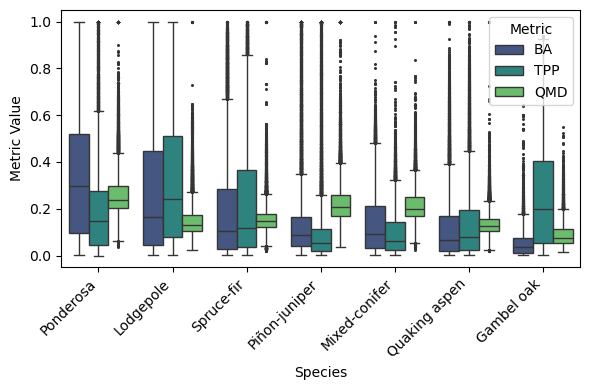

572

In [22]:
# Plot the distribution of dominance and abundance across forest species groups
# Sort species by mean dominance
sp_order = (
    grid_tm_spp_pr.groupby('species_gp_n')['ba_ld_pr']
    .mean().sort_values(ascending=False).index
)
# Reshape the data to long format for easier plotting
df_l = pd.melt(
    grid_tm_spp_pr,
    id_vars=['species_gp_n'],
    value_vars=['ba_ld_pr', 'tpp_ld_pr', 'qmd_ld_pr'],
    var_name='metric',
    value_name='value'
)

# Set up the plot
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df_l,
    x='species_gp_n',
    y='value',
    hue='metric',
    order=sp_order,
    palette='viridis',
    flierprops=dict(marker='o', markersize=1.2)
)

# Customize the plot
plt.xlabel('Species')
plt.ylabel('Metric Value')
plt.xticks(rotation=45, ha='right')

# Customize legend labels
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['BA', 'TPP', 'QMD']  # New labels
plt.legend(
    handles=handles, 
    labels=new_labels,  # Replace default labels
    title='Metric', 
    loc='upper right', 
    bbox_to_anchor=(1, 1)
)

# Finalize and show the plot
plt.tight_layout()

# Save the plot
out_png = os.path.join(projdir, 'figures/FigureSX_TopSpecies_TreeMetrics_Proportions.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

del df_l
gc.collect()

In [23]:
# save the file.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_treetable.csv')
grid_tm_spp_pr.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/gridstats_treetable.csv


In [ ]:
# merge back to the frp data
grid.drop(columns=['forest_pixels','forest_pct'], inplace=True)
grid_tm_frp = grid.merge(grid_tm_spp_pr, on='grid_index', how='inner')
grid_tm_frp.columns

In [ ]:
del grid_tm_spp, grid_tm_spp_pr
gc.collect()

In [ ]:
grid_tm_frp['species_gp_n'].unique()

In [ ]:
# Save this table out.
# First, extract centroid coords
df = grid_tm_frp.copy()
df = df.to_crs(4326) # WGS coords for lat/lon
df['x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['y'] = df.geometry.centroid.y 
# remove the geomtry field before exporting
df.drop(columns=['geometry'], inplace=True)

# save the file.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_treetable_frp.csv')
df.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

del df
gc.collect()

In [ ]:
# plot the distribution of percent cover by forest types
grid_tm_frp['species_gp_n'] = grid_tm_frp['species_gp_n'].astype('category')

spp_order = top_species[top_species['species_gp_n'].isin(grid_tm_frp['species_gp_n'].unique())]
spp_order = spp_order['species_gp_n'].tolist()
grid_tm_frp['species_gp_n'] = pd.Categorical(
    grid_tm_frp['species_gp_n'],
    categories=spp_order,
    ordered=True
)

# Create a FacetGrid with the specified order
g = sns.FacetGrid(
    data=grid_tm_frp,
    col='species_gp_n',      
    col_wrap=3,             
    sharex=False,            
    sharey=False,            
    height=2,               
    aspect=1.2              
)

# Map a KDE plot to each facet
g.map(sns.kdeplot, 'ba_ld_pr', fill=True, alpha=0.6)

# Customize the plot
g.set_titles("{col_name}")  # Use species names as titles
g.set_axis_labels("Dominance (basal area)", "Density", size=9)  # Axis labels
g.fig.set_size_inches(6,4)  # Set figure dimensions
plt.subplots_adjust(top=0.9)  # Adjust subplot spacing

# Show the plot
plt.show()

In [ ]:
df_long = pd.melt(
    grid_tm_frp,
    id_vars=['species_gp_n'],
    value_vars=['ba_ld_pr', 'tpp_ld_pr', 'qmd_ld_pr'],
    var_name='metric',
    value_name='value'
)

# Set the order of species
spp_order = top_species[top_species['species_gp_n'].isin(spps)]
spp_order = spp_order['species_gp_n'].tolist()
df_long['species_gp_n'] = pd.Categorical(
    df_long['species_gp_n'],
    categories=spp_order,
    ordered=True
)

# Just plot one species
df_long = df_long[df_long['species_gp_n'] == 'Quaking aspen']

# Create the plot with stacked densities
plt.figure(figsize=(6,4))

# Use seaborn's KDE plot for each metric, with species as rows (stacked)
sns.kdeplot(
    data=df_long,
    x='value',
    hue='metric',  # Separate densities by metric
    multiple='stack',  # Stack densities
    fill=True,         # Fill densities for stacking effect
    palette='viridis',
    alpha=0.6
)

# Customize the plot
plt.xlabel("Proportion Value (Dominance/Abundance)", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(title="Metric", labels=["BA", "TPP", "QMD"], fontsize=9)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Species co-occurrence plot
# Threshold species presence where dominance/abundance > 1% of total
dt = 0.01
# Create a binary presence-absence matrix
pres_abs = (
    grid_tm_frp
    .pivot_table(index='grid_index', columns='species_gp_n', values='ba_ld_pr', aggfunc='first')
    .fillna(0)
    .applymap(lambda x: 1 if x >= dt else 0)  # Convert to binary
)

# get the species names and matrix
species = pres_abs.columns
coo_mat = pd.DataFrame(0, index=species, columns=species)
# map across species combinations
for sp1, sp2 in combinations(species, 2):
    # Count co-occurrence (grids where both species are present)
    coo = np.sum(pres_abs[sp1] & pres_abs[sp2])
    coo_mat.loc[sp1, sp2] = coo
    coo_mat.loc[sp2, sp1] = coo  # Symmetry

# Optional: Normalize by the total number of grids for each species
species_totals = pres_abs.sum(axis=0)
norm_mat = coo_mat.div(species_totals, axis=0)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    norm_mat, 
    annot=True, 
    fmt=".2f", 
    cmap="YlGnBu", 
    cbar_kws={'label': 'Co-Occurrence Frequency'}
)
plt.xlabel("Species")
plt.ylabel("Species")
plt.tight_layout()

out_png = os.path.join(projdir, 'figures/FigureX_Species_CoOccurrence.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()